# Cardiovascular Desease Prediction Project.

This project is for education purposes. here I will exercise skills in machine learning, more precisely classification algorithms.

[data source: Kaggle](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset/code)


**Data Description:**

There are 3 types of input features:

* Objective: factual information;
* Examination: results of medical examination;
* Subjective: information given by the patient.

Features:

* Age | Objective Feature | age | int (days)
* Height | Objective Feature | height | int (cm) |
* Weight | Objective Feature | weight | float (kg) |
* Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men |
* Systolic blood pressure | Examination Feature | ap_hi | int |
* Diastolic blood pressure | Examination Feature | ap_lo | int |
* Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
* Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
* Smoking | Subjective Feature | smoke | binary | 0: no, 1: yes |
* Alcohol intake | Subjective Feature | alco | binary | 0: no, 1: yes |
* Physical activity | Subjective Feature | active | binary | 0: no, 1: yes |
* Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 0: no, 1: yes |

All of the dataset values were collected at the moment of medical examination.


**Created Features:**

* BMI - Body mass index | 0: Underweight, 1: Normal, 2: Overweight, 3: Obesity 1, 4: Obesity 2, 5: Morbid obesity
* cat_blood_pressure | 0: Normal, 1: Elevated, 2: Hypertension 1, 3: Hypertension 2, 4: Hypertension 3.

# Imports

In [91]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score,
from sklearn.metrics import precision_score, f1_score, cohen_kappa_score,balanced_accuracy_score

warnings.filterwarnings('ignore')

# Helper Functions

In [8]:
SEED = 43

%matplotlib inline
%pylab inline

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['font.size'] = 18

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.expand_frame_repr', False)

sns.set()


# Function to categorize BMI feature
def cat_bmi(bmi):
    if bmi >= 17 and bmi < 18.5:
        return int(0) # 0: underweight
    elif bmi >= 18.5 and bmi < 25:
        return int(1) # 1: normal
    elif bmi >= 25 and bmi < 30:
        return int(2) # 2: elevated
    elif bmi >= 30 and bmi < 35:
        return int(3) # 3: overweight
    elif bmi >= 35 and bmi < 40:
        return int(4) # 4: obesity
    else:
        return int(5) # 5: morbid obesity

    
# Function to annotate bar vaues in the graphs.
def annot_plot(plot):
    for p in plot.patches:
        plot.annotate(format(int(p.get_height())), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize = 14)
    return None

Populating the interactive namespace from numpy and matplotlib


# Load Data

In [9]:
df1 = pd.read_csv('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\data\\cardio_train.csv',
                 sep = ';', 
                 index_col = 'id')
df1.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Data Description

In [10]:
df1.dtypes

age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [11]:
# Cheking for NAN data.

df1.isnull().sum().sum()

0

In [12]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19468.865814,2467.251667,10798.0,17664.0,19703.0,21327.0,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.0,1.0,2.0,2.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.0,1.0,2.0,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.0,1.0,1.0,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,70000.0,0.053771,0.225568,0.0,0.0,0.0,0.0,1.0


In [13]:
df1.shape

(70000, 12)

# Data Cleaning

## Data Questions Based on Data Features Describe.

**Height:** The minimum height is 55cm and the maximum is 250 cm. Is that right? There are patients with nanism or gigantism in the dataset?

In [14]:
# Checking if there are many height outliers and the impact of it on the entire dataset.

shorter = len(df1[df1["height"] < 130])
bigger = len(df1[df1["height"] > 210])

print(f'There are {shorter} patients with height under 130cm'
      f' and {bigger} patient bigger than 210cm.'
      f'\nIt corresponds to {round((bigger + shorter) * 100 / len(df1), 2)}% of the dataset.')

There are 92 patients with height under 130cm and 1 patient bigger than 210cm.
It corresponds to 0.13% of the dataset.


In [15]:
# The patients under 130cm and bigger than 210cm will be excluded from dataset.

df2 = df1[df1["height"] >= 130]
df2 = df2[df2["height"] <= 210]

**Weight:** The minimum weight is 10kg and the maximum is 200kg. Is that right?patients with just 10kg?

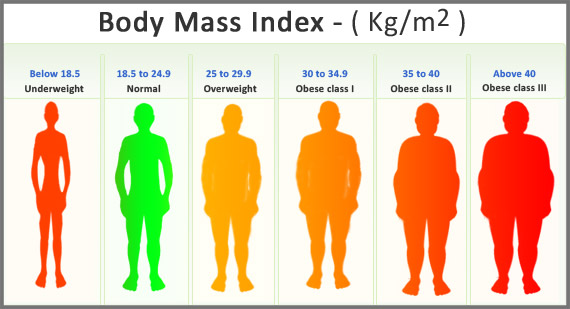

In [16]:
# Checking for outliers in the weight feature.

thinner = len(df2[df2['weight'] < 40])
print(f'There are {thinner} patients with weight under 40kg.')

There are 50 patients with weight under 40kg.


In [17]:
# Excluding patients with less than 40kg.

df2 = df2[df2['weight'] > 40]

**Blood pressure:** There are blood pressures with negative values, is that possible?

- After some research I saw that it is possible to a blood pressure be negative, but in order to the low impact on the dataset, we decided to exclude them.



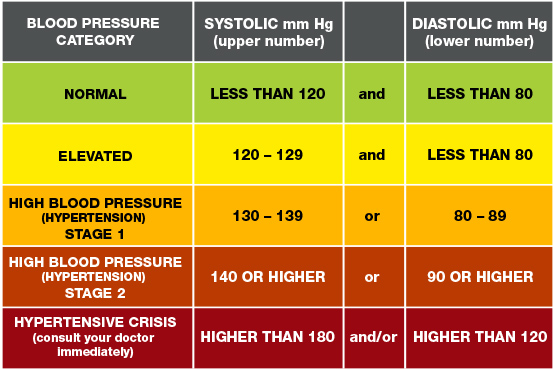



In [18]:
negative_ap_hi = len(df2[df2['ap_hi'] < 0])
negative_ap_lo = len(df2[df2['ap_lo'] < 0])

print(f'There are {negative_ap_hi} cases of negative ap_hi and {negative_ap_lo} cases of negative ap_lo')

There are 7 cases of negative ap_hi and 1 cases of negative ap_lo


In [19]:
# The negative blood pressure cases and to low or to high will be excluded.

df2 = (df2[df2['ap_hi'] > 50])
df2 = (df2[df2['ap_hi'] < 220])
df2 = (df2[df2['ap_lo'] > 50])
df2 = (df2[df2['ap_lo'] < 180])

In [20]:
print(f'After the data cleaning ware excluded from the original dataset {df1.shape[0] - df2.shape[0]} rows.')

After the data cleaning ware excluded from the original dataset 1512 rows.


In [21]:
df2.shape

(68488, 12)

In [22]:
df2.describe().T 

,count,mean,std,min,25%,50%,75%,max
age,68488.0,19465.696443,2467.112346,10798.0,17660.75,19701.0,21323.25,23713.0
gender,68488.0,1.349083,0.476684,1.0,1.00,1.0,2.00,2.0
height,68488.0,164.458518,7.833527,130.0,159.00,165.0,170.00,207.0
weight,68488.0,74.163148,14.231677,41.0,65.00,72.0,82.00,200.0
ap_hi,68488.0,126.613743,16.606703,70.0,120.00,120.0,140.00,215.0
ap_lo,68488.0,81.403560,9.524719,52.0,80.00,80.0,90.00,170.0
cholesterol,68488.0,1.364706,0.679033,1.0,1.00,1.0,2.00,3.0
gluc,68488.0,1.226098,0.572153,1.0,1.00,1.0,1.00,3.0
smoke,68488.0,0.088074,0.283404,0.0,0.00,0.0,0.00,1.0
alco,68488.0,0.053644,0.225316,0.0,0.00,0.0,0.00,1.0


# Feature Enginnering

In [23]:
df3 = df2.copy()

In [24]:
# Transforming age from days to years
df3['age'] = df3['age'].apply(lambda x: int(x/365))

# Creating BMI Feature
df3['bmi'] = (df3['weight']/((df3['height']/100)**2)).round(2)

# Categorizing BMI
df3['cat_weight'] = df3['bmi'].apply(cat_bmi)

# Categorizing Blood Pressure
df3['cat_blood_pressure'] = df3.apply(lambda x: 0 if x['ap_hi'] < 120 and x['ap_lo'] < 80 else
                                      1 if 120 <= x['ap_hi'] < 130 and x['ap_lo'] < 80 else
                                      2 if 130 <= x['ap_hi'] < 140 or 80 <= x['ap_lo'] < 90 else
                                      3 if 140 <= x['ap_hi'] <= 180 or 90 <= x['ap_lo'] <= 120
                                      else 4, axis  =1)

In [25]:
df3.reset_index('id', inplace = True, drop = True)
df3.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,cat_weight,cat_blood_pressure
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.97,1,2
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,3,3
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.51,1,2
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.71,2,3
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.01,1,0


# EDA - Exploratory Data Analysis

In [26]:
df3.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,cat_weight,cat_blood_pressure
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.97,1,2
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,3,3
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.51,1,2
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.71,2,3
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.01,1,0


In [27]:
df4 = df3.copy()

## Univariate Ananalysis

### Age

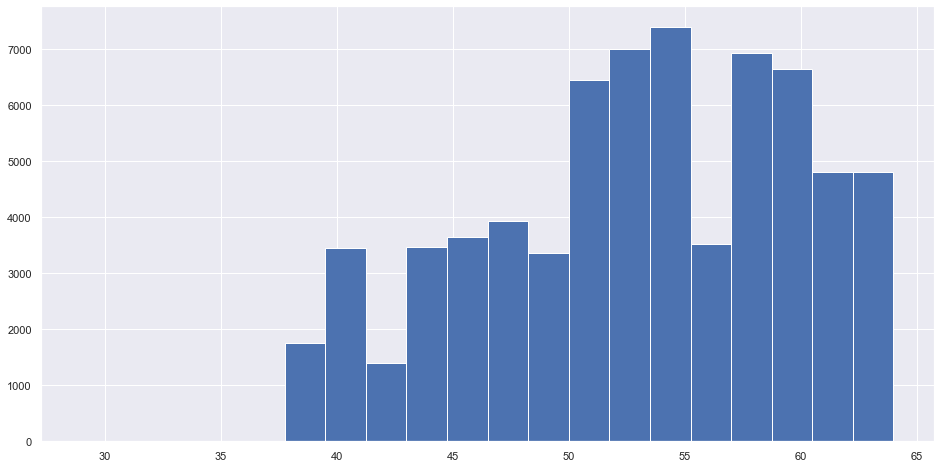

In [28]:
df4['age'].hist(bins = 20)

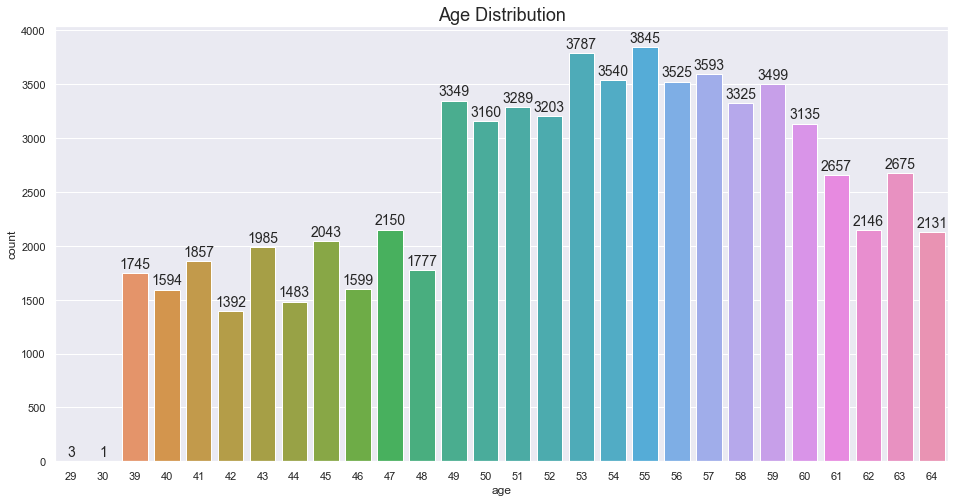

In [29]:
age_plot = sns.countplot(df4['age'])

annot_plot(age_plot)

plt.title('Age Distribution', fontsize = 18);

### Cardio Disease

In [30]:
# Disease proportion on dataset

print(f'Patients without cardio disease: {df4.cardio.value_counts()[0]} - {round((df4.cardio.value_counts()[0] / len(df4)) * 100, 2)}%'
      f'\nPatients with cardio disease: {df4.cardio.value_counts()[1]} -  {round((df4.cardio.value_counts()[1] / len(df4)) * 100, 2)}%')

Patients without cardio disease: 34576 - 50.48%
Patients with cardio disease: 33912 -  49.52%


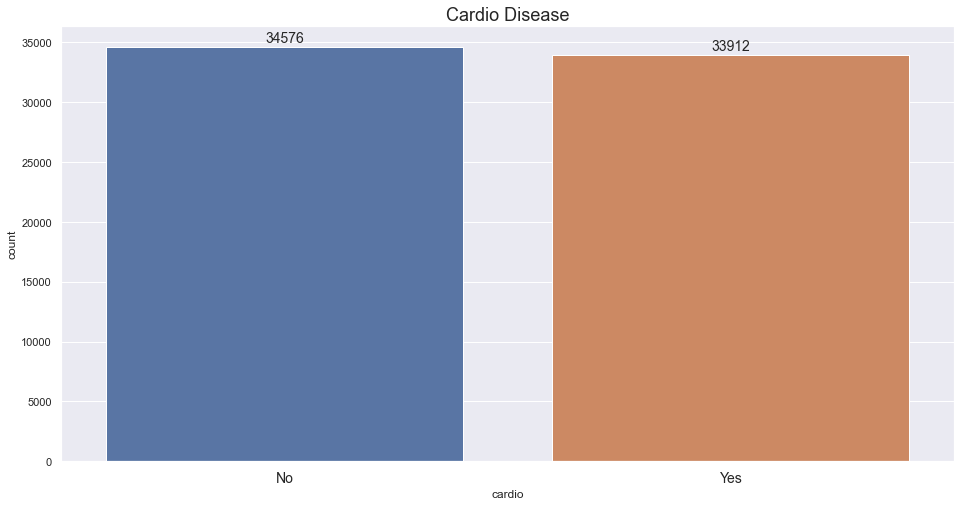

In [31]:
disease_plot = sns.countplot(df4['cardio'])

annot_plot(disease_plot)

plt.xticks([0, 1], ['No', 'Yes'], fontsize = 14, rotation = 'horizontal')
plt.title('Cardio Disease', fontsize = 18);

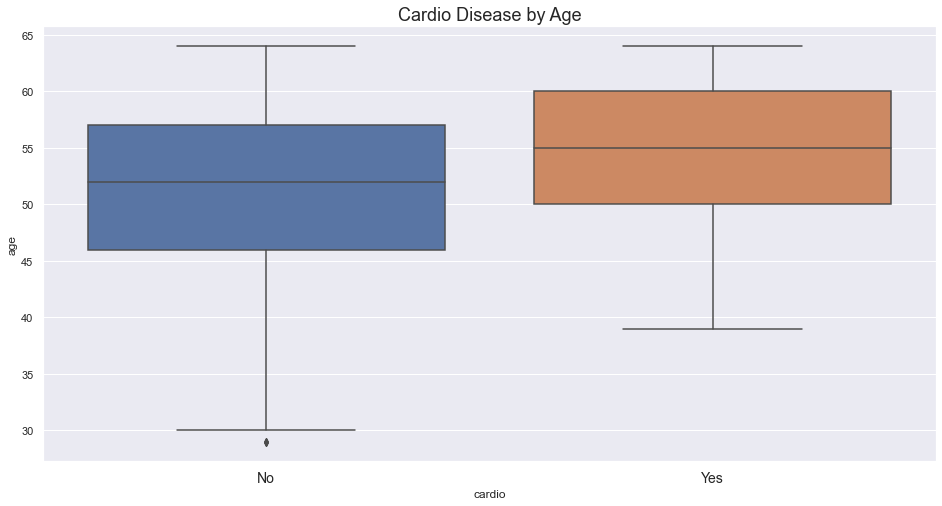

In [32]:
# Boxplot - Cardio Disease by Age.

ax = sns.boxplot('cardio', 'age', data = df4)
ax.set_title('Cardio Disease by Age', fontsize = 18)
plt.xticks([0, 1], ['No', 'Yes'], fontsize = 14)
ax;

Text(0.5, 1.0, 'Cardio Disese by Smoker')

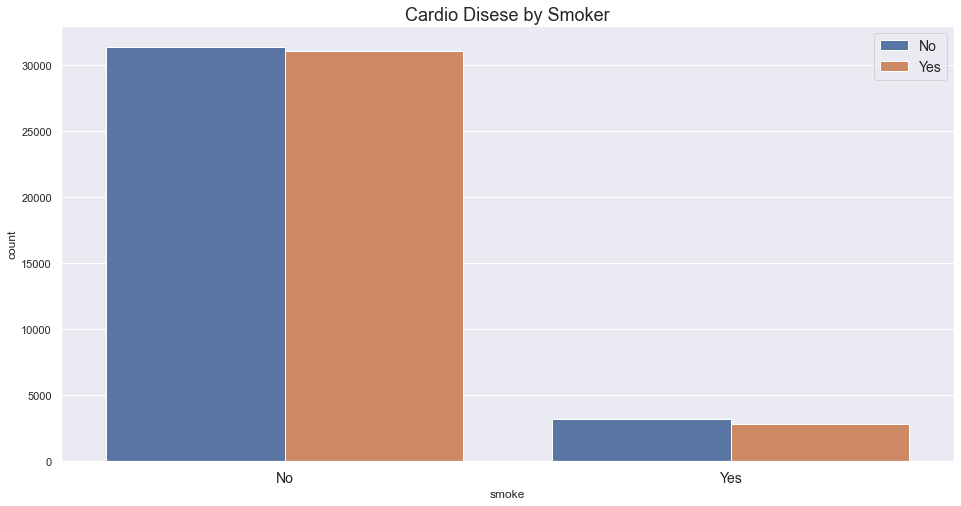

In [33]:
sns.countplot('smoke', hue = 'cardio', data = df4)

plt.xticks([0, 1], ['No', 'Yes'], fontsize = 14, rotation = 'horizontal')
plt.legend(labels = ['No', 'Yes'], fontsize = 14)
plt.title('Cardio Disese by Smoker', fontsize = 18)

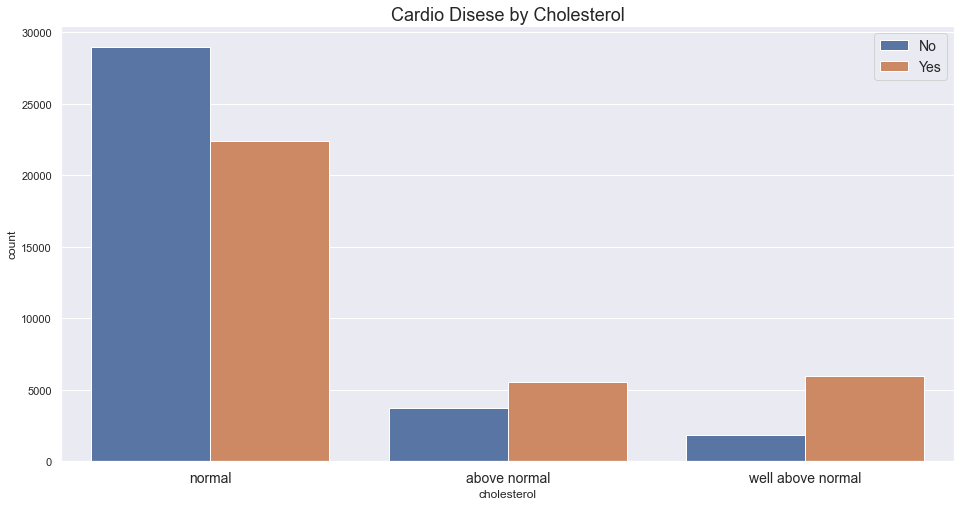

In [34]:
sns.countplot('cholesterol', hue = 'cardio', data = df4)

plt.xticks([0, 1, 2], ['normal', 'above normal', 'well above normal'], fontsize = 14, rotation = 'horizontal')
plt.legend(labels = ['No', 'Yes'], fontsize = 14)
plt.title('Cardio Disese by Cholesterol', fontsize = 18);

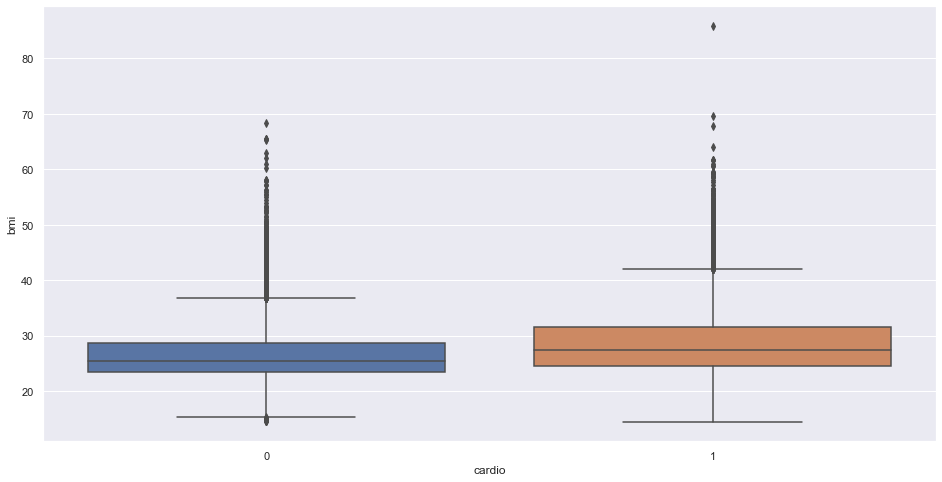

In [35]:
sns.boxplot('cardio', 'bmi', data = df4)

In [36]:
df4.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,cat_weight,cat_blood_pressure
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.97,1,2
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,3,3
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.51,1,2
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.71,2,3
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.01,1,0


### Gender

In [37]:
df4['gender'].value_counts()

1    44580
2    23908
Name: gender, dtype: int64

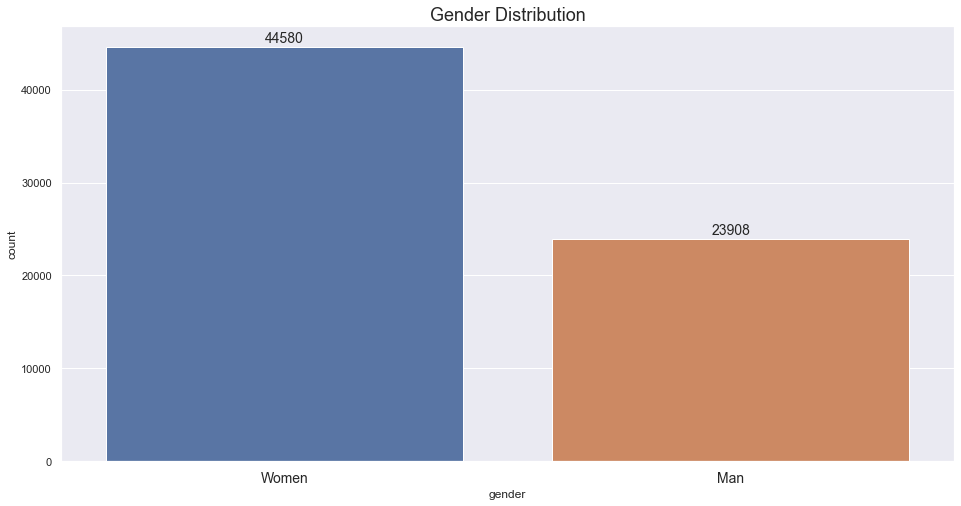

In [38]:
gender_plot = sns.countplot(df4['gender'])

annot_plot(gender_plot)

plt.title('Gender Distribution', fontsize = 18)
plt.xticks([0, 1], ['Women', 'Man'], rotation = 'horizontal', fontsize = 14);

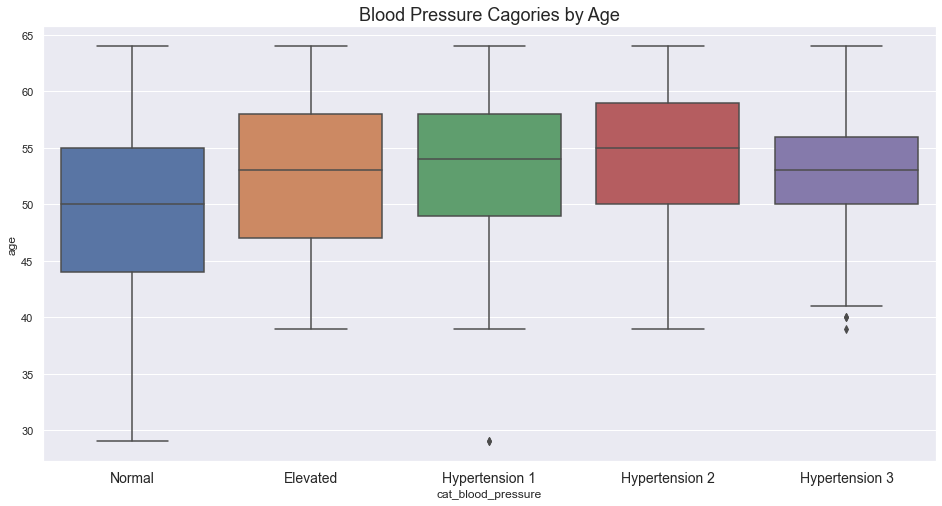

In [39]:
# BoxPlot - Blod Pressure by Age

sns.boxplot('cat_blood_pressure', 'age',data = df4)

plt.title('Blood Pressure Cagories by Age', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4], ['Normal', 'Elevated', 'Hypertension 1', 'Hypertension 2', 'Hypertension 3'], fontsize = 14);

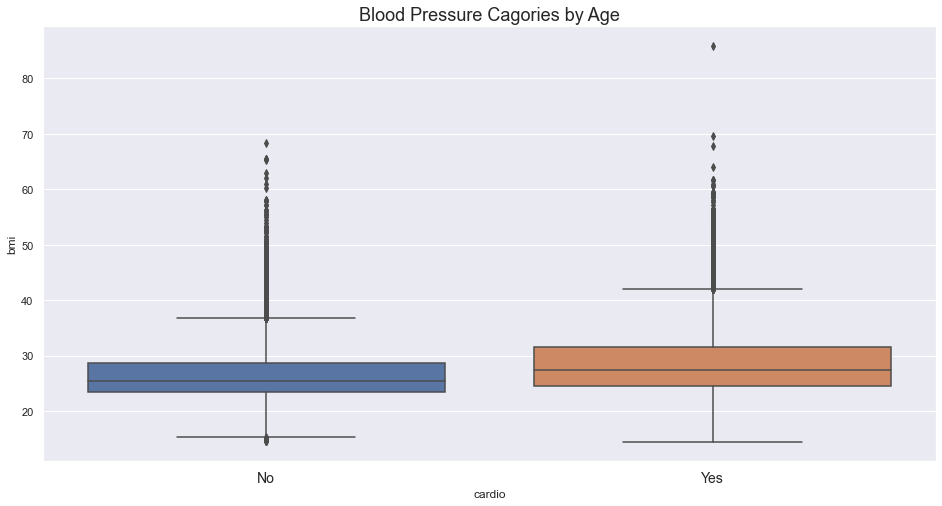

In [40]:
# Violin Plot - Cardio Disease by BMI

sns.boxplot('cardio', 'bmi',data = df4)

plt.title('Blood Pressure Cagories by Age', fontsize = 18)
plt.xticks([0, 1], ['No', 'Yes'], fontsize = 14);

### Bloob Pressure Cat.

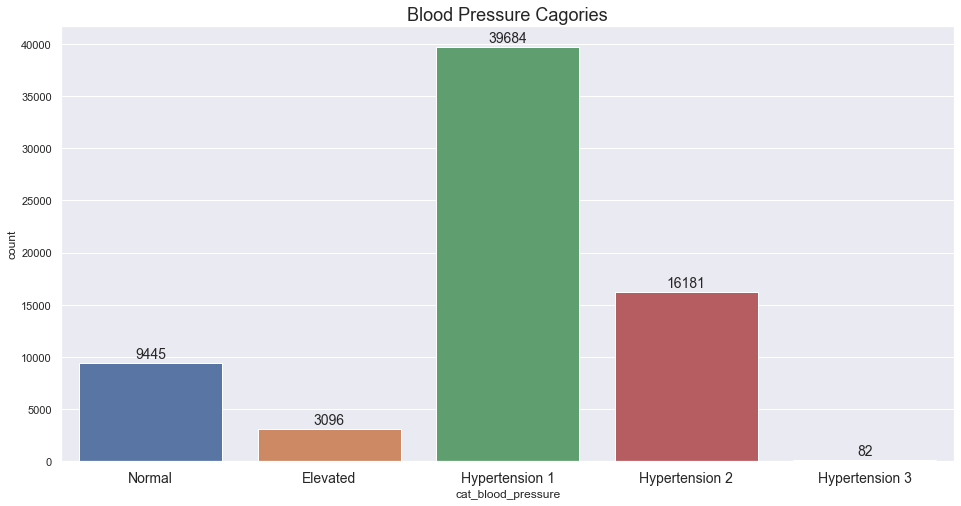

In [41]:
blod_p = sns.countplot(df4['cat_blood_pressure'])

annot_plot(blod_p)

plt.title('Blood Pressure Cagories', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4], ['Normal', 'Elevated', 'Hypertension 1', 'Hypertension 2', 'Hypertension 3'], fontsize = 14);

## Bivariate Analysis

## Multivariate Analysis

In [42]:
df4.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,cat_weight,cat_blood_pressure
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.97,1,2
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,3,3
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.51,1,2
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.71,2,3
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.01,1,0


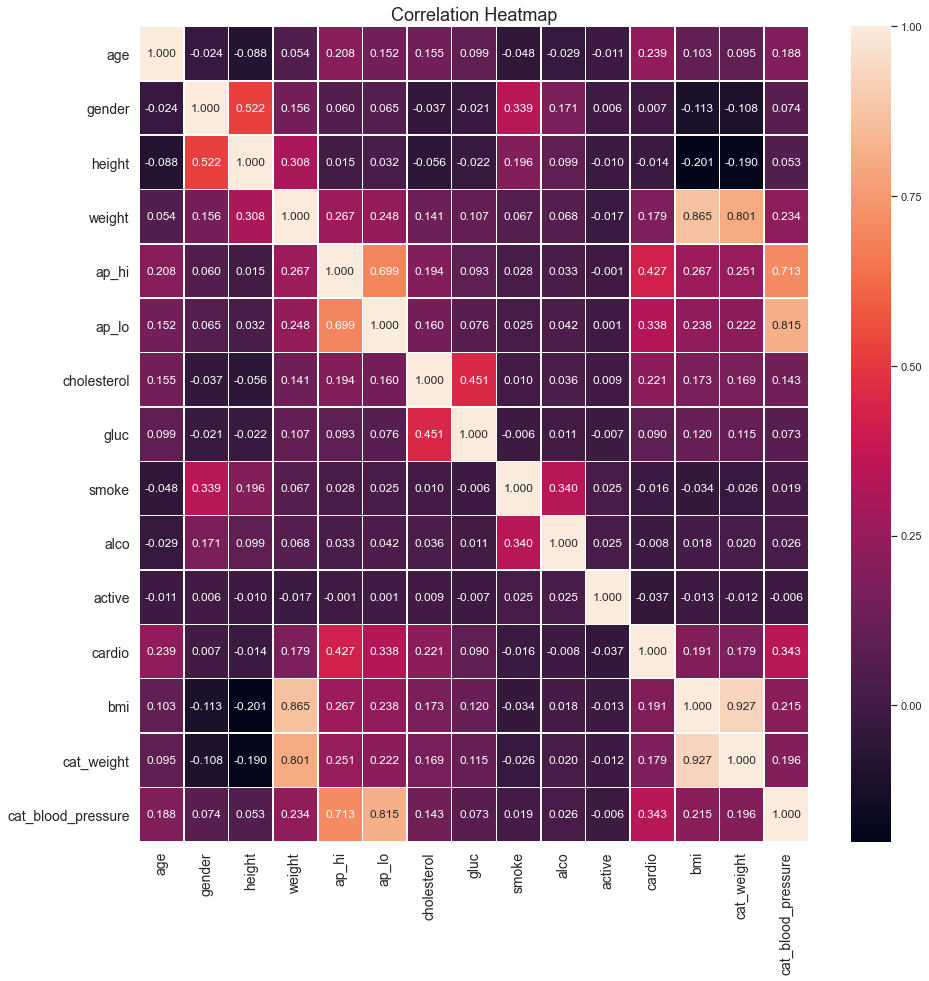

In [43]:
corr = df4.corr()

f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)
plt.title('Correlation Heatmap', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(rotation = 'horizontal', fontsize = 14);

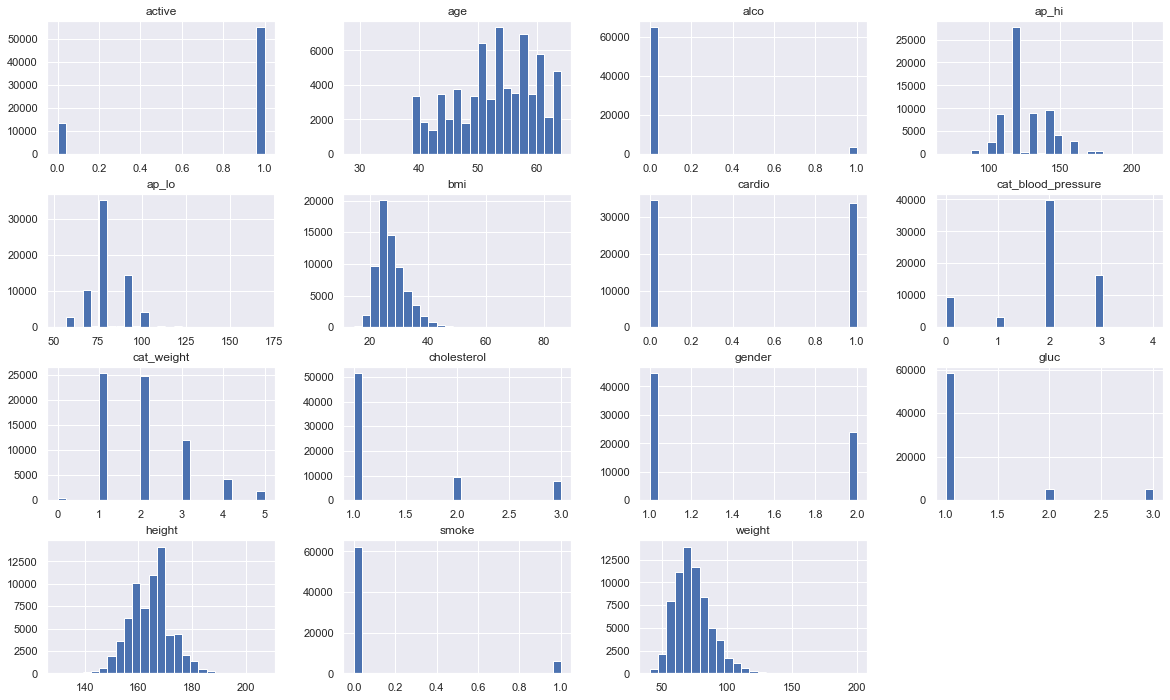

In [44]:
df4.hist(figsize = (20,12), bins = 25);

# Features Selection

In [45]:
df5 = df4.copy()
df5 = df5[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
           'alco', 'active', 'bmi', 'cat_weight', 'cat_blood_pressure', 'cardio']]

df5.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cat_weight,cat_blood_pressure,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,21.97,1,2,0
1,55,1,156,85.0,140,90,3,1,0,0,1,34.93,3,3,1
2,51,1,165,64.0,130,70,3,1,0,0,0,23.51,1,2,1
3,48,2,169,82.0,150,100,1,1,0,0,1,28.71,2,3,1
4,47,1,156,56.0,100,60,1,1,0,0,0,23.01,1,0,0


In [46]:
x = df5.drop('cardio', axis = 1)

y = df5['cardio']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = SEED,  stratify = y)

print(f'x_train: {x_train.shape[0]}\n'
      f'x_test: {x_test.shape[0]}\n\n'
      f'y_train: {y_train.shape[0]}\n'
      f'y_test: {y_test.shape[0]}')

x_train: 51366
x_test: 17122

y_train: 51366
y_test: 17122


# Machine Learning Modeling
**Classifier Models to implement:**

* **KNeighborsClassifier**

* **RandomForestClassifier**

* **XGBoostClassifier**

* **LGBMClassifier**

## KNeighborsClassifier 

In [92]:
KN_model = KNeighborsClassifier(weights = 'distance', n_jobs = -1)

KN_model.fit(x_train, y_train)
y_hat_KN = KN_model.predict(x_test)

# Evaluation Metrics
KN_cross_val__avg_acc = cross_val_score(KN_model, x_train, y_train, cv = 5).mean()
KN_precision = precision_score(y_test, y_hat_KN)
KN_recall = recall_score(y_test, y_hat_KN)
KN_f1_score = f1_score(y_test, y_hat_KN)
KN_Kappa_score = cohen_kappa_score(y_test, y_hat_KN)
KN_balanced_acc = balanced_accuracy_score(y_test, y_hat_KN)

KN_metrics = pd.DataFrame({'model':['KNN Classifier'],
                           'accuracy':[KN_cross_val__avg_acc],
                           'precision':[KN_precision],
                           'recall':[KN_recall],
                           'f1_score':[KN_f1_score],
                           'kappa_score': [KN_Kappa_score], 
                           'balanced accuracy':[KN_balanced_acc]})

KN_metrics

,model,accuracy,precision,recall,f1_score,kappa_score,balanced accuracy
0,KNN Classifier,0.683701,0.687083,0.656287,0.671332,0.363292,0.681568


In [48]:
print(classification_report(y_test, y_hat_KN))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      8644
           1       0.69      0.66      0.67      8478

    accuracy                           0.68     17122
   macro avg       0.68      0.68      0.68     17122
weighted avg       0.68      0.68      0.68     17122



## RandonForestClassifier

In [94]:
RF_model = RandomForestClassifier(n_estimators = 1500, n_jobs = -1, random_state = SEED)

RF_model.fit(x_train, y_train)
y_hat_RF = RF_model.predict(x_test)

# Evaluation Metrics
RF_cross_val__avg_acc = cross_val_score(RF_model, x_train, y_train, cv = 5).mean()
RF_precision = precision_score(y_test, y_hat_RF)
RF_recall = recall_score(y_test, y_hat_RF)
RF_f1_score = f1_score(y_test, y_hat_RF)
RF_Kappa_score = cohen_kappa_score(y_test, y_hat_RF)
RF_balanced_acc = balanced_accuracy_score(y_test, y_hat_RF)

RF_metrics = pd.DataFrame({'model':['Random Forest Classifier'],
                           'accuracy':[RF_cross_val__avg_acc],
                           'precision':[RF_precision],
                           'recall':[RF_recall],
                           'f1_score':[RF_f1_score],
                           'kappa_score':[RF_Kappa_score],
                           'balanced accuracy':[RF_balanced_acc]})

RF_metrics

,model,accuracy,precision,recall,f1_score,kappa_score,balanced accuracy
0,Random Forest Classifier,0.710334,0.708239,0.698632,0.703402,0.416409,0.708178


In [60]:
print(classification_report(y_test, y_hat_RF))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      8644
           1       0.71      0.70      0.70      8478

    accuracy                           0.71     17122
   macro avg       0.71      0.71      0.71     17122
weighted avg       0.71      0.71      0.71     17122



In [61]:
# Cross Validation RandomForest

cross_val_score(RF_model, x_train, y_train, cv = 5)

array([0.70284213, 0.71780395, 0.71254745, 0.7119634 , 0.70651222])

## XGBoost Classifier

In [95]:
XGB_model = xgb.XGBClassifier(n_jobs = -1)

XGB_model.fit(x_train, y_train)
y_hat_XGB = XGB_model.predict(x_test)

# Evaluation Metrics
XGB_cross_val__avg_acc = cross_val_score(XGB_model, x_train, y_train, cv = 5).mean()
XGB_precision = precision_score(y_test, y_hat_XGB)
XGB_recall = recall_score(y_test, y_hat_XGB)
XGB_f1_score = f1_score(y_test, y_hat_XGB)
XGB_Kappa_score = cohen_kappa_score(y_test, y_hat_XGB)
XGB_balanced_acc = balanced_accuracy_score(y_test, y_hat_XGB)


XGB_metrics = pd.DataFrame({'model':['XGB Classifier'],
                           'accuracy':[XGB_cross_val__avg_acc],
                           'precision':[XGB_precision],
                           'recall':[XGB_recall],
                           'f1_score':[XGB_f1_score],
                           'kappa_score': [XGB_Kappa_score],
                           'balanced accuracy':[XGB_balanced_acc]})

XGB_metrics

[18:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,model,accuracy,precision,recall,f1_score,kappa_score,balanced accuracy
0,XGB Classifier,0.729218,0.742438,0.691908,0.716283,0.456784,0.728243


In [63]:
print(classification_report(y_test, y_hat_XGB))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      8644
           1       0.74      0.69      0.72      8478

    accuracy                           0.73     17122
   macro avg       0.73      0.73      0.73     17122
weighted avg       0.73      0.73      0.73     17122



In [64]:
# Cross Validation XGBoost Classifier

cross_val_score(XGB_model, x_train, y_train, cv = 5)

[20:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

array([0.72357407, 0.73172394, 0.73376813, 0.73016646, 0.72685681])

## LGBMClassifier

In [98]:
LGBM_model = LGBMClassifier(random_state = SEED, n_jobs = -1)

LGBM_model.fit(x_train, y_train)
y_hat_LGBM = LGBM_model.predict(x_test)

LGBM_cross_val__avg_acc = cross_val_score(LGBM_model, x_train, y_train, cv = 5).mean()
LGBM_precision = precision_score(y_test, y_hat_LGBM)
LGBM_recall = recall_score(y_test, y_hat_LGBM)
LGBM_f1_score = f1_score(y_test, y_hat_LGBM)
LGBM_Kappa_score = cohen_kappa_score(y_test, y_hat_LGBM)
LGBM_balanced_acc = balanced_accuracy_score(y_test, y_hat_LGBM)

LGBM_metrics = pd.DataFrame({'model':['LGBM Classifier'],
                           'accuracy':[LGBM_cross_val__avg_acc],
                           'precision':[LGBM_precision],
                           'recall':[LGBM_recall],
                           'f1_score':[LGBM_f1_score],
                           'kappa_score':[LGBM_Kappa_score],
                           'balanced accuracy':[LGBM_balanced_acc]})

LGBM_metrics

,model,accuracy,precision,recall,f1_score,kappa_score,balanced accuracy
0,LGBM Classifier,0.734649,0.748475,0.694621,0.720543,0.465998,0.732838


In [66]:
print(classification_report(y_test, y_hat_LGBM))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      8644
           1       0.75      0.69      0.72      8478

    accuracy                           0.73     17122
   macro avg       0.73      0.73      0.73     17122
weighted avg       0.73      0.73      0.73     17122



## Best Model

In [99]:
best_model = pd.concat([KN_metrics, RF_metrics, XGB_metrics, LGBM_metrics], axis = 0)
best_model.to_dict(orient = 'list')

{'model': ['KNN Classifier',
  'Random Forest Classifier',
  'XGB Classifier',
  'LGBM Classifier'],
 'accuracy': [0.6837014294649963,
  0.710333829609155,
  0.7292178803841046,
  0.7346494827855189],
 'precision': [0.687083230427266,
  0.7082386703336123,
  0.7424376661182129,
  0.7484748347737672],
 'recall': [0.6562868601085161,
  0.6986317527718802,
  0.6919084689785326,
  0.694621372965322],
 'f1_score': [0.6713320463320464,
  0.7034024107832076,
  0.7162830453629648,
  0.720543252171785],
 'kappa_score': [0.36329189535803186,
  0.416409265094589,
  0.45678356204913095,
  0.46599838690652906],
 'balanced accuracy': [0.6815677706373214,
  0.7081775145164353,
  0.7282425269464621,
  0.7328382200319438]}

In [100]:
best_model = {'model': ['KNN Classifier', 'Random Forest Classifier', 'XGB Classifier',  'LGBM Classifier'],
              'accuracy': [0.6837014294649963, 0.710333829609155, 0.7292178803841046, 0.7346494827855189],
              'precision': [0.687083230427266, 0.7082386703336123, 0.7424376661182129, 0.7484748347737672],
              'recall': [0.6562868601085161, 0.6986317527718802, 0.6919084689785326, 0.694621372965322],
              'f1_score': [0.6713320463320464, 0.7034024107832076, 0.7162830453629648, 0.720543252171785],
              'kappa_score': [0.36329189535803186, 0.416409265094589, 0.45678356204913095, 0.46599838690652906],
              'balanced accuracy': [0.6815677706373214, 0.7081775145164353, 0.7282425269464621, 0.7328382200319438]}

best_model = pd.DataFrame(best_model)
best_model.sort_values(by = 'accuracy', ascending = False, inplace = True)
best_model.reset_index(inplace = True, drop = True)
best_model

,model,accuracy,precision,recall,f1_score,kappa_score,balanced accuracy
0,LGBM Classifier,0.734649,0.748475,0.694621,0.720543,0.465998,0.732838
1,XGB Classifier,0.729218,0.742438,0.691908,0.716283,0.456784,0.728243
2,Random Forest Classifier,0.710334,0.708239,0.698632,0.703402,0.416409,0.708178
3,KNN Classifier,0.683701,0.687083,0.656287,0.671332,0.363292,0.681568


## Hyperparameter Fine Tunning - Random Search - XGBoost

In [101]:
params = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7], 
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 10

In [102]:
#XGB_tunn_perfomance = pd.DataFrame()
results_list = []

for p in range(MAX_EVAL):
    # Choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0]for k, v in params.items()}
    print(p, hp)
    
    # model
    xgb_model = xgb.XGBClassifier(n_estimator = hp['n_estimators'],
                                  max_depth = hp['max_depth'],
                                  subsample = hp['subsample'],
                                  colsample_bytree = hp['colsample_bytree'],
                                  min_child_weight = hp['min_child_weight'])
    
    # Performance
    result = cross_val_score(xgb_model, x_train, y_train, cv = 5).mean()
    results_list.append(result)
    #XGB_tunn_perfomance['result'] = results_list[p]

#XGB_tunn_perfomance

0 {'n_estimators': 3500, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
[18:30:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some param

In [103]:
pd.DataFrame(results_list)

,0
0,0.729666
1,0.734163
2,0.730113
3,0.733442
4,0.713663
5,0.727505
6,0.733034
7,0.728751
8,0.730697
9,0.717109


In [ ]:
best_xbg = {'n_estimators': 1500, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}

## Hyperparameter Fine Tunning - Random Search - LGBM

    - Using RandomizedSearchCV.

In [106]:
params_lgbm = {'max_depth': np.arange(2, 12, 2), 
               'num_leaves': 2 ** np.arange(2, 10, 2),
               'min_data_in_leaf': np.arange(100, 1050, 50), 
               'learning_rate': np.linspace(0.001, 0.6, 15),
               'colsample_bytree': np.linspace(0.1, 1, 5),
               'subsample': np.linspace(0.25, 1, 15),
               'n_estimators': np.arange(10, 105, 15)}

In [111]:
lgbm_classifier = RandomizedSearchCV(estimator = LGBM_model, param_distributions = params_lgbm,
                                scoring='f1', n_iter=100, cv=5, verbose=2,
                                random_state=SEED, n_jobs=-1)

lgbm_classifier.fit(x_train, y_train)
lgbm_classifier.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900


LGBMClassifier(colsample_bytree=0.55, learning_rate=0.08657142857142856,
               max_depth=10, min_data_in_leaf=900, n_estimators=70,
               num_leaves=16, random_state=43, subsample=0.30357142857142855)

In [112]:
LGBM_model = LGBMClassifier(colsample_bytree=0.55,
                            learning_rate=0.08657142857142856,
                            max_depth=10,
                            min_data_in_leaf=900,
                            n_estimators=70,
                            num_leaves=16,
                            random_state=43,
                            subsample=0.30357142857142855)

LGBM_model.fit(x_train, y_train)
y_hat_LGBM = LGBM_model.predict(x_test)

LGBM_cross_val__avg_acc = cross_val_score(LGBM_model, x_train, y_train, cv = 5).mean()
LGBM_precision = precision_score(y_test, y_hat_LGBM)
LGBM_recall = recall_score(y_test, y_hat_LGBM)
LGBM_f1_score = f1_score(y_test, y_hat_LGBM)
LGBM_Kappa_score = cohen_kappa_score(y_test, y_hat_LGBM)
LGBM_balanced_acc = balanced_accuracy_score(y_test, y_hat_LGBM)

LGBM_metrics = pd.DataFrame({'model':['LGBM Classifier'],
                           'accuracy':[LGBM_cross_val__avg_acc],
                           'precision':[LGBM_precision],
                           'recall':[LGBM_recall],
                           'f1_score':[LGBM_f1_score],
                           'kappa_score':[LGBM_Kappa_score],
                           'balanced accuracy':[LGBM_balanced_acc]})

LGBM_metrics

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900


,model,accuracy,precision,recall,f1_score,kappa_score,balanced accuracy
0,LGBM Classifier,0.735097,0.750288,0.692498,0.720236,0.466791,0.733223


# Work Diary

* 10/03/21 - Started Cardiovascular_disease_prediction project
    - Done some data description analysis.
    - Started Feature Enginnering.
    
    
* 11/03/21 - Done some more fearture enginnering.
    - Finished first sicle of feature enginnering.
    - started EDA
    
    
* 13/03/21 - EDA.
    - Done some graph analysis.
    
    
* 15/03/21 - ML models
    - Testing some Classifier ML algorithms.
    - Evaluate ML algorithms performance.
    
    
* 16/03/21
    - Done finetunning for XGBoost and LGBM Classifiers.
    - Test RandomizedSearchCV for LGBM.
    
    - Best Results:
    
|model          |accuracy|precision|recall  |f1_score|kappa_score|balanced accuracy|
|---------------|:------:|:-------:|:------:|:------:|:---------:|:---------------:|
|LGBM Classifier|0.735097|0.750288 |0.692498|0.720236|0.466791   |0.733223         |